# ICU demand

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import minimize 
from datetime import timedelta
import datetime as dt
from IPython.display import Image
import requests

## Data

### Brazil

#### COVID-19 DATA

Data source: [Brasil.IO](https://brasil.io/dataset/covid19/caso). Observe the database changes every day.



In [2]:
url = "https://brasil.io/dataset/covid19/caso/?format=csv"
filename = 'data/brazil_' + url.split("/")[-3] + '.csv'
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

To keep the same analysis, we keep the data basis from May 11.

In [2]:
#filename = 'data/brazil_covid19_05_11.csv'

df = pd.read_csv(filename)
df.head()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-05-13,AC,Acrelândia,city,39,1,True,15256.0,1200013.0,255.63713,0.0256
1,2020-05-13,AC,Assis Brasil,city,1,0,True,7417.0,1200054.0,13.48254,0.0000
2,2020-05-13,AC,Brasiléia,city,3,0,True,26278.0,1200104.0,11.41639,0.0000
3,2020-05-13,AC,Bujari,city,16,0,True,10266.0,1200138.0,155.85428,0.0000
4,2020-05-13,AC,Capixaba,city,1,0,True,11733.0,1200179.0,8.52297,0.0000


Select a particular state or city:

In [3]:
state_or_city = 'city'

name = ['São Paulo', 'Caieiras', 'Cajamar', 'Francisco Morato', 'Franco da Rocha', 'Mairiporã', 'Arujá', 'Biritiba-Mirim', 'Ferraz de Vasconcelos', 'Guararema', 'Guarulhos', 'Itaquaquecetuba', 'Mogi das Cruzes', 'Poá', 'Salesópolis', 'Santa Isabel', 'Suzano', 'Diadema', 'Mauá', 'Ribeirão Pires', 'Rio Grande da Serra', 'Santo André', 'São Bernardo do Campo', 'São Caetano do Sul', 'Cotia', 'Embu', 'Embu-Guaçu', 'Itapecerica da Serra', 'Juquitiba', 'São Lourenço da Serra', 'Taboão da Serra', 'Vargem Grande Paulista', 'Barueri', 'Carapicuíba', 'Itapevi', 'Jandira', 'Osasco', 'Pirapora do Bom Jesus', 'Santana de Parnaíba']

df = df[ df['place_type'] == state_or_city]
df = df[ df['city'].isin(name) ]

df_I = df.groupby('date')[['confirmed']].sum()
df_I.index = pd.to_datetime(df_I.index)
today = df_I.index[-1] + timedelta(days=1)

Last day of data used to run this notebook:

In [97]:
fit_until = df_I.index[-1].strftime('%m-%d')
fit_until

'05-13'

Eventually, data for some days are not avalible depending on the city or state. Thus, the must be a shift in the model to take these absent days into accont.

In [19]:
start = df_I.index[0]
end = df_I.index[-1]
time_I = pd.date_range(start, end, freq='D')

shift_NaN = np.abs( len(time_I) - len(df_I.index) )  

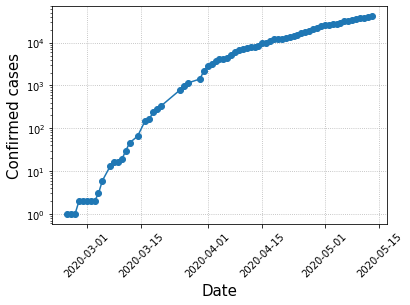

In [20]:
fig, ax = plt.subplots()
ax.plot(df_I, 'o-', color= 'C0')
ax.set_yscale('log')
ax.grid(linestyle=':')
ax.set_xlabel('Date', fontsize= 15)
ax.set_ylabel('Confirmed cases', fontsize= 15)
plt.xticks(rotation=45)
plt.show()

In [21]:
today = df_I.index[-1] + timedelta(days=1)

#### Population data combined with ICU adimission probability by age

Data source: [IBGE](https://www.ibge.gov.br/apps/populacao/projecao/).

In [22]:
file = 'data/pop_age_str_IBGE_2020_' + 'SP' + '.csv'
#file = 'data/pop_age_str_IBGE_2020_' + name + '.csv'

df_age = pd.read_csv(file)
df_age.loc[0, 'Age'] = '00-04'
df_age.loc[1, 'Age'] = '05-09'
df_age['AGE_prob'] = df_age['Total'] / df_age['Total'].sum()

pop0 = 	21571281
#pop0 = df_age['Total'].sum()

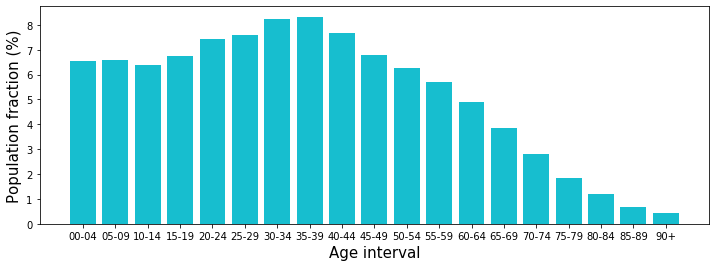

In [23]:
fig, ax = plt.subplots(figsize= (12, 4))
ax.bar(df_age['Age'], 100*df_age['AGE_prob'], color = 'C9')
ax.set_xlabel('Age interval', fontsize= 15)
ax.set_ylabel('Population fraction (%)', fontsize= 15)

#filename = 'results/figures/FIGURE_AGE_str_' + state_or_city + '_' + name
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

Data source: [Severe Outcomes Among Patients with Coronavirus Disease 2019 (COVID-19) — United States, February 12–March 16, 2020](https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm?s_cid=mm6912e2_w) by [CDC](https://www.cdc.gov/).

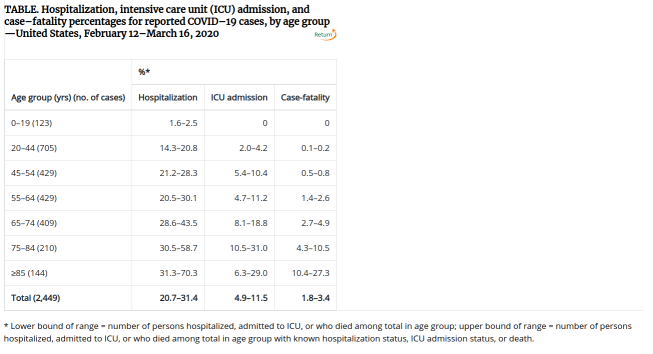

In [24]:
Image(filename= 'results/figures/CDC_ICU_age.png') 

In [25]:
df_age_ICU = pd.DataFrame(columns=['Age', 'ICU_prob'])
df_age_ICU['Age'] = ['0-19', '20-44', '45-54', '55-64', '65-74', '75-84', '85+']
df_age_ICU['ICU_prob'] = [0, 4.2, 10.4, 11.2, 18.8, 31, 29]

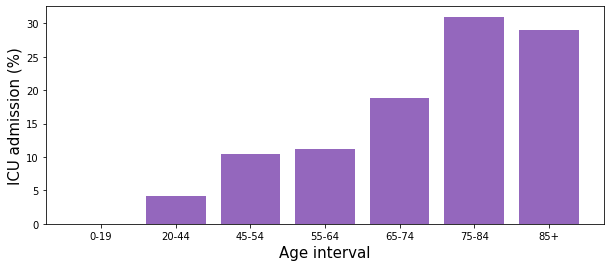

In [26]:
fig, ax = plt.subplots(figsize= (10, 4 ))
ax.bar(df_age_ICU['Age'], df_age_ICU['ICU_prob'], color = 'C4')
ax.set_xlabel('Age interval', fontsize= 15)
ax.set_ylabel('ICU admission (%)', fontsize= 15)

#filename = 'results/figures/FIGURE_AGE_ICU'
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

In [27]:
ICU_prob = [0., 0., 0., 0., 0.042, 
            0.042, 0.042, 0.042, 0.042, 0.104,
            0.104, 0.112, 0.112, 0.188, 0.188,
            0.31, 0.31, 0.29, 0.29]

df_age['ICU_prob'] = ICU_prob

### World

#### COVID-19 data

Data source: [Our World in Data](https://github.com/owid/covid-19-data/tree/master/public/data). Observe the database changes every day.

In [28]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
filename = 'data/world_' + url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

To keep the same analysis, we keep the data basis from May 11.

In [29]:
#filename = 'data/world_owid-covid-data_05_11.csv'

df_W = pd.read_csv(filename)
df_W = df_W[df_W.location != 'Hong Kong']
df_W = df_W[df_W['iso_code'].notna()]
df_W.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


We focus on two scenarios defined on the other notebook (cite).

## Fit sigmoid over data

$$ n(t) =  \frac{n^{*}}{1 + e^{-\alpha(t - t_0)}} \equiv S(t) \hat{n}(t)  \; \; \, $$

where $S(t)$ is a subnotification factor, $t_0$ is the time from which the fit is performed.



In [55]:
country1 = 'Spain'
country2 = 'Switzerland'

frac1 = list(df_W[ df_W['location'] == country1]['total_cases_per_million'])[-1] / 10**6
frac2 = list(df_W[ df_W['location'] == country2]['total_cases_per_million'])[-1] / 10**6

#n_star1 = (frac1 * pop0).item()
#n_star2 = (frac2 * pop0).item()
n_star1 = frac1 * pop0
n_star2 = frac2 * pop0

Last days of world data used to run this notebook:

In [91]:
list(df_W[ df_W['location'] == country1]['date'])[-1]

'2020-05-13'

In [93]:
list(df_W[ df_W['location'] == country2]['date'])[-1]

'2020-05-14'

### Linear regression over $\log(n^{*} / n(t)  - 1 )$

In [56]:
S = 1

X_ = np.arange(len(df_I))
X = X_.reshape(-1, 1)

# The model is fitted with a subnotification factor
y1 = np.log( n_star1 / np.array( S * df_I) - 1. )
y1 = y1.reshape(len(df_I)).reshape(-1, 1)

y2 = np.log( n_star2 / np.array( S * df_I) - 1. )
y2 = y2.reshape(len(df_I)).reshape(-1, 1)

In [57]:
t0 = 45

model1 = linear_model.LinearRegression()
model2 = linear_model.LinearRegression()

model1.fit(X[t0:], y1[t0:])
model2.fit(X[t0:], y2[t0:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

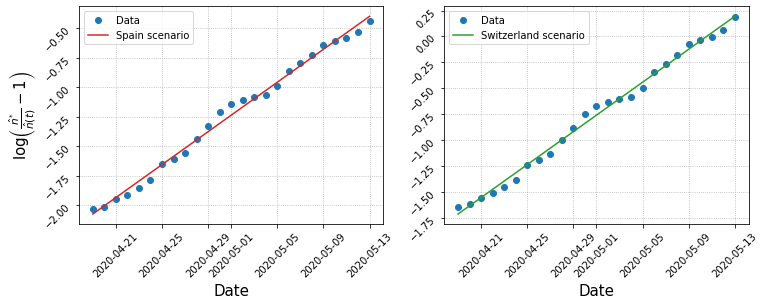

In [58]:
fig, axs = plt.subplots(1, 2, figsize= (12, 4))

axs[0].plot(df_I.index[t0:], -y1[t0:], 'o', color= 'C0', label= 'Data')
axs[0].plot(df_I.index[t0:], -model1.predict(X)[t0:], color= 'C3', label= country1 + ' scenario')
axs[0].grid(linestyle=':')
axs[0].set_xlabel('Date', fontsize= 15)
axs[0].set_ylabel('$ \\log \\left( \\frac{\\hat{n}^{*}}{\\hat{n}(t)} - 1 \\right) $', fontsize= 15)
axs[0].tick_params(labelrotation= 45)
axs[0].legend()

axs[1].plot(df_I.index[t0:], -y2[t0:], 'o', color= 'C0', label= 'Data')
axs[1].plot(df_I.index[t0:], -model2.predict(X)[t0:], color= 'C2', label= country2 + ' scenario')
axs[1].grid(linestyle=':')
axs[1].set_xlabel('Date', fontsize= 15)
axs[1].tick_params(labelrotation= 45)
axs[1].legend()
plt.show()

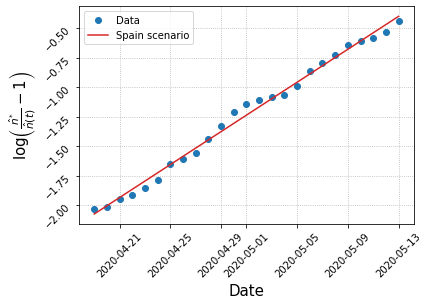

In [59]:
fig, axs = plt.subplots()

axs.plot(df_I.index[t0:], -y1[t0:], 'o', color= 'C0', label= 'Data')
axs.plot(df_I.index[t0:], -model1.predict(X)[t0:], color= 'C3', label= country1 + ' scenario')
axs.grid(linestyle=':')
axs.set_xlabel('Date', fontsize= 15)
axs.set_ylabel('$ \\log \\left( \\frac{\\hat{n}^{*}}{\\hat{n}(t)} - 1 \\right) $', fontsize= 15)
axs.tick_params(labelrotation= 45)
axs.legend()

#filename = 'results/figures/FIGURE_FIT_' + state_or_city + '_' + name + '_Spain'
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

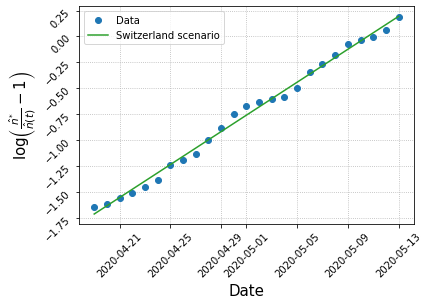

In [60]:
fig, axs = plt.subplots()

axs.plot(df_I.index[t0:], -y2[t0:], 'o', color= 'C0', label= 'Data')
axs.plot(df_I.index[t0:], -model2.predict(X)[t0:], color= 'C2', label= country2 + ' scenario')
axs.grid(linestyle=':')
axs.set_xlabel('Date', fontsize= 15)
axs.set_ylabel('$ \\log \\left( \\frac{\\hat{n}^{*}}{\\hat{n}(t)} - 1 \\right) $', fontsize= 15)
axs.tick_params(labelrotation= 45)
axs.legend()

#filename = 'results/figures/FIGURE_FIT_' + state_or_city + '_' + name + '_Germany'
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

### Number of infected projections

In [61]:
def sigmoid(t, t0, alpha, n_star, shift_NaN= 0):
    return n_star / (1. + np.exp(-alpha*(t - t0 - shift_NaN)))

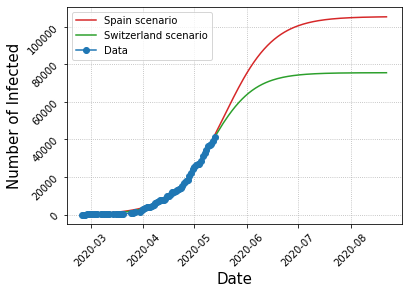

In [62]:
X__ = np.arange(0, 180)

start = df_I.index[0]
end = pd.to_datetime(start, format='%Y/%m/%d') + pd.DateOffset(days= len(X__) - 1)
time = pd.date_range(start, end, freq='D')

n1 = sigmoid(X__, 
             t0= -model1.intercept_[0] / model1.coef_[0][0], 
             alpha= -model1.coef_[0][0], 
             n_star= n_star1,
             shift_NaN= shift_NaN)

n2 = sigmoid(X__, 
             t0= -model2.intercept_[0] / model2.coef_[0][0], 
             alpha= -model2.coef_[0][0], 
             n_star= n_star2,
             shift_NaN= shift_NaN)


fig, ax = plt.subplots()

ax.plot(time, 
        sigmoid(X__, 
                t0= -model1.intercept_[0] / model1.coef_[0][0], 
                alpha= -model1.coef_[0][0], 
                n_star= n_star1,
                shift_NaN= shift_NaN), 
        color= 'C3', label= country1 + ' scenario')


ax.plot(time, 
        sigmoid(X__, 
                t0= -model2.intercept_[0] / model2.coef_[0][0], 
                alpha= -model2.coef_[0][0], 
                n_star= n_star2,
                shift_NaN= shift_NaN), 
        color= 'C2', label= country2 + ' scenario')

ax.plot(df_I.index, np.array(S * df_I['confirmed']), 'o-', color= 'C0', label= 'Data')

ax.grid(linestyle=':')
ax.set_xlabel('Date', fontsize= 15)
ax.set_ylabel('Number of Infected', fontsize= 15)
ax.tick_params(labelrotation= 45)
ax.legend()

#filename = 'results/figures/FIGURE_FITs_I_' + state_or_city + '_' + name
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

## Sampling from age-structed population probability and ICU admission probability

Function to be used to performe both sampling over time.

In [73]:
def ICU_samp(df, n, n_samp_AGE_max= 1000, n_samp_AGE_min= 100, n_samp_ICU_max= 1000, n_samp_ICU_min= 100, error_AGE= 0.1, error_ICU= 0.1):

    df_samp = pd.DataFrame(columns= df['Age'])

    #mean0 = np.zeros(len(df['Age']))

    for j in range(n_samp_AGE_max):
    
        samp = np.random.choice(df['Age'], 
                                n, 
                                p= list(df['AGE_prob']) )

        unique, counts = np.unique(samp, return_counts= True)
    
        for l in range(len(unique)):
            df_samp.loc[j, unique[l]] = counts[l]

        #### Check error_AGE difference for all ages
        #mean = df_samp.mean(axis= 0)    
        #error = (np.abs(np.array(mean0) - np.array(mean)) <= error_AGE).sum()
        
        #if error == len(df['Age']):
        #    if j > n_samp_AGE_min:
        #        print('j_break_1 = ', j)
        #        break
        
        #mean0 = np.copy(mean)
        ####

    df_samp = df_samp.fillna(0)
    df['n_mean'] = list(df_samp.mean(axis= 0))
    df['n_std']  = list(df_samp.std(axis =0))

    df = df.set_index('Age')

    for age in df.index:
    
        aux_ = []
        #mean0 = 0.

        for j in range(n_samp_ICU_max):      
    
            samp = np.random.uniform(size= int(df.loc[age]['n_mean']))  
            samp_ICU = samp < df.loc[age]['ICU_prob']
            aux_.append(samp_ICU.sum())

            #error = np.abs( mean0 - np.mean(aux_))
            #mean0 = np.mean(aux_)
        
            #if error < error_ICU:
            #    if j > n_samp_ICU_min:
            #        print('j_break_2 = ', j)
            #        break

        df.loc[age, 'n_mean_ICU']  = np.mean(aux_)
        df.loc[age, 'n_std_ICU']   = np.std(aux_)
        
    df['n_std_ICU'] = np.sqrt( df['n_std']**2 +  df['n_std_ICU']**2)
    
    return df

Running the function over both scenarios:

In [74]:
df1_ = []
df2_ = []

for j in range(len(n1)):
    
    df1 = ICU_samp(df= df_age.reset_index(), 
                   n= int(n1[j]), 
                   n_samp_AGE_max= 1000, n_samp_AGE_min= 100,
                   n_samp_ICU_max= 1000, n_samp_ICU_min= 100,
                   error_AGE= 0.00001, error_ICU= 0.00001)

    df2 = ICU_samp(df= df_age.reset_index(), 
                   n = int(n2[j]), 
                   n_samp_AGE_max= 1000, n_samp_AGE_min= 100,
                   n_samp_ICU_max= 1000, n_samp_ICU_min= 100, 
                   error_AGE= 0.00001, error_ICU= 0.00001)
    
    df1_.append(df1)
    df2_.append(df2)

### Taking into account removal from ICU after `T_ICU` days

In [75]:
def correction(x, df_, T_ICU= 14):

    df_[x]['n_mean_ICU_cor'] = 0.
    df_[j]['n_std_ICU_cor'] = 0.
    
    if x <= T_ICU:
                   
        df_[x]['n_mean_ICU_cor'] = df_[x]['n_mean_ICU']
        df_[x]['n_std_ICU_cor']   = df_[x]['n_std_ICU']
             
    else:
        
        delta = df_[x]['n_mean_ICU'] - df_[x - T_ICU]['n_mean_ICU']
        
        df_[x]['n_mean_ICU_cor'] = np.heaviside(delta, 0) * delta
        df_[x]['n_std_ICU_cor']  = np.sqrt(df_[x]['n_std_ICU']**2 + df_[x - T_ICU]['n_std_ICU']**2)

In [76]:
T_ICU = 14

for x in range(len(df1_)):
    
    correction(x, df_= df1_, T_ICU= T_ICU)
    correction(x, df_= df2_, T_ICU= T_ICU)

## Collecting daily averages

Given a list `df_` of dataframes, the function `daily_av` collect averages of collumns values over a `timeseries_data` period. The return is a daaframe called `df_ICU`.

In [77]:
def daily_av(df_, timeseries_data, SUS= True, p_SUS= 0.6278, n_samp_max= 1000, n_samp_min= 100, error= 0.001):

    n_mean_    = []
    n_std_     = []
    n_mean_ICU_ = []
    n_std_ICU_  = []

    for j in range(len(df_)):

        n_mean_.append(df_[j]['n_mean'].sum())
        n_std_.append( np.sqrt((df_[j]['n_std']**2).sum()) )
        
        n_mean_ICU_.append(df_[j]['n_mean_ICU_cor'].sum())
        n_std_ICU_.append( np.sqrt((df_[j]['n_std_ICU_cor']**2).sum()) )

    names = ['date', 'n_mean', 'n_std', 'n_mean_ICU', 'n_std_ICU']
    df_ICU = pd.DataFrame(columns= names)
    df_ICU['date'] = timeseries_data

    df_ICU['n_mean']     = n_mean_ 
    df_ICU['n_std']      = n_std_
    df_ICU['n_mean_ICU'] = n_mean_ICU_
    df_ICU['n_std_ICU']  = n_std_ICU_

    df_ICU = df_ICU.set_index(['date'])


    if SUS:

        for date in df_ICU.index:
            
            aux_ = []
            #mean0 = 0.

            for j in range(n_samp_max):

                samp = np.random.uniform(size= int(df_ICU.loc[date]['n_mean_ICU']))  
                SUS_samp = samp <= p_SUS
                aux_.append(SUS_samp.sum())

                #error_ = np.abs( mean0 - np.mean(aux_))
                #mean0 = np.mean(aux_)
        
                #if error_ < error:
                #    if j > n_samp_min:
                #        break

            df_ICU.loc[date, 'n_mean_ICU_SUS'] = np.mean(aux_)
            df_ICU.loc[date, 'n_std_ICU_SUS']  = np.std(aux_)

        df_ICU['n_std_ICU_SUS'] = np.sqrt( df_ICU['n_std_ICU']**2 +  df_ICU['n_std_ICU_SUS']**2)

    return df_ICU

In [78]:
df1_ICU = daily_av(df1_, timeseries_data= time, SUS= True, p_SUS= 0.6278, n_samp_max= 1000, n_samp_min= 100, error= 0.00001)
df2_ICU = daily_av(df2_, timeseries_data= time, SUS= True, p_SUS= 0.6278, n_samp_max= 1000, n_samp_min= 100, error= 0.00001)

## Median between two scenarios

In [79]:
df_median = pd.DataFrame(columns= ['date', 'median', 'std', 'median_SUS', 'std_SUS'])

df_median['date'] = df1_ICU.index
df_median['median'] = np.median([df1_ICU['n_mean_ICU'], df2_ICU['n_mean_ICU']], axis=0)
df_median['std'] = np.median([df1_ICU['n_std_ICU'], df2_ICU['n_std_ICU']], axis=0)
df_median['median_SUS'] = np.median([df1_ICU['n_mean_ICU_SUS'], df2_ICU['n_mean_ICU_SUS']], axis=0)
df_median['std_SUS'] = np.median([df1_ICU['n_std_ICU_SUS'], df2_ICU['n_std_ICU_SUS']], axis=0)
df_median = df_median.set_index('date')

df_median.index = pd.to_datetime(df_median.index)

## Private ICU beds

In [11]:
df1_ICU['n_mean_ICU_PRIVATE'] = df1_ICU['n_mean_ICU'] - df1_ICU['n_mean_ICU_SUS'] 
df1_ICU['n_std_ICU_PRIVATE'] = np.sqrt(  df1_ICU['n_std_ICU']**2 + df1_ICU['n_std_ICU_SUS']  )

df2_ICU['n_mean_ICU_PRIVATE'] = df2_ICU['n_mean_ICU'] - df2_ICU['n_mean_ICU_SUS'] 
df2_ICU['n_std_ICU_PRIVATE'] = np.sqrt(  df2_ICU['n_std_ICU']**2 + df2_ICU['n_std_ICU_SUS']  )

df_median['median_PRIVATE'] = df_median['median'] - df_median['median_SUS'] 
df_median['std_PRIVATE'] = np.sqrt(  df_median['median']**2 + df_median['median_SUS']  )

#### Saving the results. 

In [12]:
#name = 'grande_SP'

#file1 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country1 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
#file2 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country2 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
#file3 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + 'MEDIAN' + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'


#df1_ICU.to_pickle(file1) 
#df2_ICU.to_pickle(file2) 
#df_median.to_pickle(file3)

#### Loading the results

In [10]:
#name = 'grande_SP'

#file1 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country1 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
#file2 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country2 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
#file3 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + 'MEDIAN' + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'


#df1_ICU = pd.read_pickle(file1) 
#df2_ICU = pd.read_pickle(file2) 
#df_median = pd.read_pickle(file3)

## Plots


In [101]:
df_ICU_data = pd.DataFrame(columns= ['date', 'n_data_ICU'])
df_ICU_data['date'] = time
df_ICU_data = df_ICU_data.set_index(['date'])

cap = 1170

df_ICU_data.loc['2020-05-09', 'n_data_ICU'] = cap*0.87
df_ICU_data.loc['2020-05-07', 'n_data_ICU'] = cap*0.896
df_ICU_data.loc['2020-05-06', 'n_data_ICU'] = cap*0.86
df_ICU_data.loc['2020-05-04', 'n_data_ICU'] = cap*0.871
df_ICU_data.loc['2020-05-02', 'n_data_ICU'] = cap*0.875
df_ICU_data.loc['2020-04-29', 'n_data_ICU'] = cap*0.784
df_ICU_data.loc['2020-04-28', 'n_data_ICU'] = cap*0.81
df_ICU_data.loc['2020-04-25', 'n_data_ICU'] = cap*0.773
df_ICU_data.loc['2020-04-23', 'n_data_ICU'] = cap*0.74
df_ICU_data.loc['2020-04-22', 'n_data_ICU'] = cap*0.733

In [102]:
def plot_scenarios(df1, df2, df_median, dfdata,
                   country1, country2, data_SUS= False, fit_until= '05-13', 
                   error1= True, error2= True, errorm= False, 
                   SUS= False, ylim= 10000, capacity= 5017, file_s= 'state_SP', Z= 1., save= False, pdf= False):

    if SUS:
        file_s = file_s + '_SUS'
        n_mean = 'n_mean_ICU_SUS'
        n_std  = 'n_std_ICU_SUS'
        median = 'median_SUS'
        std = 'std_SUS'
        y_label = 'Number of ICU beds (SUS)'
        plot_data = False

    else:
        n_mean = 'n_mean_ICU'
        n_std  = 'n_std_ICU'
        median = 'median'
        std = 'std'
        y_label = 'Number of ICU beds'
        plot_data = True

        

    fig, ax = plt.subplots()

    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    dfdata.index = pd.to_datetime(dfdata.index)

    ############################################################################
    ###### SUBNOTIFICATION FACTOR

    if data_SUS:
        n_mean_opt = 'n_mean_ICU_SUS'
        fitted = 'fitted with SUS data'
    else:
        n_mean_opt = 'n_mean_ICU'
        fitted = 'fitted with non-SUS data'

    df1_data = df1.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]
    df2_data = df2.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]
    dfdata_data = dfdata.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]

    def error_(x):
        median = np.median([df1_data[n_mean_opt ], df2_data[n_mean_opt]], axis=0)
        error = ((dfdata_data['n_data_ICU'] - x*median)**2).sum()
        return error


    sub = minimize(error_, x0=10).x[0]

    ###############################
    ######## MEDIAN

    ax = (sub*df_median[median][today:]).plot(color= 'gold', label= 'Median', linewidth= 2.5)

    if errorm:
        ax.fill_between(df_median[today:].index,
                        sub*(df_median[median][today:] - Z*df_median[std][today:]),
                        sub*(df_median[median][today:] + Z*df_median[std][today:]),
                        alpha= 0.3, color= 'gold')

    ymaxm   = sub*(df_median.loc[df_median[median].idxmax()].loc[median])
    yerrorm = Z*df_median.loc[df_median[median].idxmax()].loc[std] * sub

    if capacity > 0:
        colapse_m = df_median[ sub*df_median[median] > capacity ].index.tolist()
        if len(colapse_m) > 0:
            colapse_datem = colapse_m[0].strftime('%Y-%m-%d')
        else:
            colapse_datem = 'no colapse'
    else:
        colapse_datem = 'capacity not informed'

    
    ############################################################################
    ###### DATA
    if plot_data:
        ax = dfdata['n_data_ICU'].plot(marker= 'o', color= 'C1', label= 'Data')

    ############################################################################
    ###### AFTER TODAY
    ax = (sub*df1[n_mean][today:]).plot(label= country1, color= 'C3')

    if error1:
        ax.fill_between(df1[today:].index,
                        sub*(df1[n_mean][today:] - Z*df1[n_std][today:]),
                        sub*(df1[n_mean][today:] + Z*df1[n_std][today:]),
                        alpha= 0.3, color= 'C3')

    ymax1   =  df1.loc[df1[n_mean].idxmax()].loc[n_mean] * sub
    yerror1 = Z*df1.loc[df1[n_mean].idxmax()].loc[n_std] * sub

    if capacity > 0:
        colapse_1 = df1[ sub*df1[n_mean] > capacity ].index.tolist()
        if len(colapse_1) > 0:
            colapse_date1 = colapse_1[0].strftime('%Y-%m-%d')
        else:
            colapse_date1 = 'no colapse'
    else:
        colapse_date1 = 'capacity not informed'

    ############################################################################
    ax = (sub*df2[n_mean][today:]).plot(label= country2, color= 'C2')

    if error2:
        ax.fill_between(df2[today:].index,
                        sub*(df2[n_mean][today:] - Z*df2[n_std][today:]),
                        sub*(df2[n_mean][today:] + Z*df2[n_std][today:]),
                        alpha= 0.3, color= 'C2')

    ymax2   = df2.loc[df2[n_mean].idxmax()].loc[n_mean] * sub
    yerror2 = Z*df2.loc[df2[n_mean].idxmax()].loc[n_std] * sub

    if capacity > 0:
        colapse_2 = df2[ sub*df2[n_mean] > capacity ].index.tolist()
        if len(colapse_2) > 0:
            colapse_date2 = colapse_2[0].strftime('%Y-%m-%d')
        else:
            colapse_date2 = 'no colapse'
    else:
        colapse_date2 = 'capacity not informed'

    ############################################################################
    ###### BEFORE TODAY
    ax = (sub*df1[n_mean][:today]).plot(color= 'C7', label='_nolegend_')

    ax.fill_between(df1[:today].index,
                    sub*(df1[n_mean][:today] - Z*df1[n_std][:today]),
                    sub*(df1[n_mean][:today] + Z*df1[n_std][:today]),
                    alpha= 0.3, color= 'gray')



    ############################################################################
    ax = (sub*df2[n_mean][:today]).plot(color= 'C7', label='_nolegend_')

    ax.fill_between(df2[:today].index,
                    sub*(df2[n_mean][:today] - Z*df2[n_std][:today]),
                    sub*(df2[n_mean][:today] + Z*df2[n_std][:today]),
                    alpha= 0.3, color= 'gray')

    ax.set_ylabel(y_label,fontsize= 14)
    ax.set_xlabel('Date', fontsize= 14)
    ax.set_ylim([0, ylim])

    if capacity > 0:
        ax.axhline(y= capacity, color= 'C0', label= 'Capacity', linestyle= ':', linewidth= 2.0)

    ############################################################################
    l_inf1 = sub*(df1[n_mean] - Z*df1[n_std])
    l_sup1 = sub*(df1[n_mean] + Z*df1[n_std])

    colapse_int1_ = df1[ ( capacity >= l_inf1 ) & ( capacity <= l_sup1)].index
    colapse_int1 = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_int1_]

    l_inf2 = sub*(df2[n_mean] - Z*df2[n_std])
    l_sup2 = sub*(df2[n_mean] + Z*df2[n_std])

    colapse_int2_ = df2[ ( capacity >= l_inf2 ) & ( capacity <= l_sup2)].index
    colapse_int2 = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_int2_]

    l_infm = sub*(df_median[median] - Z*df_median[std])
    l_supm = sub*(df_median[median] + Z*df_median[std])

    colapse_intm_ = df_median[ ( capacity >= l_infm ) & ( capacity <= l_supm)].index
    colapse_intm = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_intm_]
    ############################################################################
    
    ax.legend(loc= 'upper left')

    filename = 'results/figures/FIGURE_ICU_' + file_s

    if save:
        f = open(filename + '.txt', 'w')
        f.write(file_s + '\n')
        f.write(country1 + ' --- max: ' + str(ymax1) + ' +- ' + str(yerror1) + ' date: ' + df1[n_mean].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' +                      colapse_date1 + '\n')
        f.write(country2 + ' --- max: ' + str(ymax2) + ' +- ' + str(yerror2) + ' date: ' + df2[n_mean].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' +                      colapse_date2 +  '\n')
        f.write('median' + ' --- max: ' + str(ymaxm) + ' +- ' + str(yerrorm) + ' date: ' + df_median[median].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' + 
                colapse_datem + '\n')
        f.write('sub factor = ' + str(sub) + ' --- ' + fitted + '\n')
        f.write('scenarios fitted with ' + file_s + ' data until: ' + fit_until + '\n')
        f.write('-----------' + '\n')
        f.write(country1 + ' --- colapse interval: ' + str(colapse_int1) + '\n')
        f.write('-----' + '\n')
        f.write(country2 + ' --- colapse interval: ' + str(colapse_int2) + '\n')
        f.write('-----' + '\n')
        f.write('median' + ' --- colapse interval: ' + str(colapse_intm) + '\n')
        f.close()

        if pdf:
            plt.savefig(filename + '.pdf', bbox_inches='tight')
        else:
            plt.savefig(filename + '.png', bbox_inches='tight')

    plt.show()

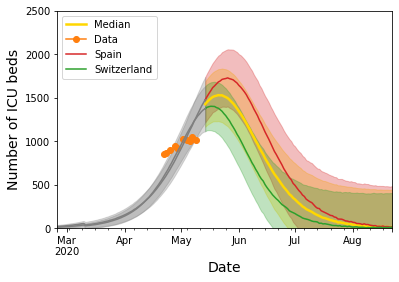

In [105]:
cap_frac = 0

plot_scenarios(df1= df1_ICU, df2= df2_ICU, df_median= df_median, dfdata= df_ICU_data,
               country1= country1, country2= country2, data_SUS= False, fit_until= fit_until,
               error1= True, error2= True, errorm= True, 
               SUS= False, ylim= 2500, capacity= cap_frac*1300,  file_s= 'grande_SP',
               Z= 1, save= False, pdf= False)